# MLP For Name generation

In [ ]:
with open('names.txt', 'r') as file:
    dataset = file.read().split('\n')

In [ ]:
dataset[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [ ]:
# Tokenizer
chars = sorted(list(set(''.join(dataset))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Hyperparameters
train_split, val_split = 0.8, 0.1 # Test is remainder
context_width = 3
vocab_size = len(chars) + 1
embed_dim = 16
layer_one_size = 300
batch_size = 256
learning_rate = 0.1
num_iters = 200000

In [ ]:
# Our model takes inputs of context_width tokens at a time, so convert our input dataset into the expected form
def build_dataset(words):
    n_grams = []
    labels = []
    for name in words:
        name = ('.' * context_width) + name + ('.')
        for i in range(context_width, len(name)):
            n_grams.append([stoi[ch] for ch in name[i-context_width:i]])
            labels.append(stoi[name[i]])

    n_grams = torch.tensor(n_grams).to(device)
    labels = torch.tensor(labels).to(device)
    print(n_grams.shape, labels.shape)
    return (n_grams, labels)

In [ ]:
# Create the train, val, and test split
split_1_index = int(train_split*len(dataset))
split_2_index = int((train_split+val_split)*len(dataset))

import random
random.seed(42)
random.shuffle(dataset)
train_dataset, train_labels = build_dataset(dataset[:split_1_index])
val_dataset, val_labels = build_dataset(dataset[split_1_index:split_2_index])
test_dataset, test_labels = build_dataset(dataset[split_2_index:])


torch.Size([182484, 3]) torch.Size([182484])
torch.Size([22869, 3]) torch.Size([22869])
torch.Size([22793, 3]) torch.Size([22793])


In [ ]:
# Create the embedding table
g = torch.Generator('cuda').manual_seed(2147483647)
embedding = torch.randn((vocab_size, embed_dim), generator=g, device=device)

# Create layer 1
W1 = torch.randn((embed_dim*context_width, layer_one_size), generator=g, device=device)
B1 = torch.randn(layer_one_size, generator=g, device=device)

# Create layer 2
W2 = torch.randn((layer_one_size, vocab_size), generator=g, device=device)
B2 = torch.randn(vocab_size, generator=g, device=device)

parameters = [embedding, W1, B1, W2, B2]
for p in parameters:
    p.requires_grad = True

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total
embedding.shape, W1.shape, B1.shape, W2.shape, B2.shape

(torch.Size([27, 16]),
 torch.Size([48, 600]),
 torch.Size([600]),
 torch.Size([600, 27]),
 torch.Size([27]))

In [ ]:
def forward_pass(dataset, labels, all=False):
    # get batch
    if all:
        embeddings = embedding[dataset]
    else:
        indices = torch.randint(0, dataset.shape[0], (batch_size,)).to(device)
        embeddings = embedding[dataset[indices]]

    #print(embeddings.shape)
    h = torch.tanh(embeddings.view(embeddings.shape[0], embeddings.shape[1]*embeddings.shape[2]) @ W1 + B1)
    #print(h.shape)
    logits = h @ W2 + B2
    #print(logits.shape)

    if all:
        loss = F.cross_entropy(logits, labels)
    else:
        loss = F.cross_entropy(logits, labels[indices])

    return loss

def get_loss(all=False):
    return forward_pass(train_dataset, train_labels, all=all)

def get_val_loss(all=False):
    with torch.no_grad():
        return forward_pass(val_dataset, val_labels, all=all)

In [ ]:
val_dataset.shape, val_labels.shape

(torch.Size([22860, 3]), torch.Size([22860]))

In [ ]:
# Define the forward pass
lossi = []
stepi = []

def train(num_epochs, lr):
    print_step = 0.1*num_epochs
    lr_step = 0.3*num_epochs
    
    for i in range(num_epochs):
        loss = get_loss()
        
        for p in parameters:
            p.grad = None
        loss.backward()

        if i % lr_step == 0:
            lr *= 0.1
        for p in parameters:
            p.data += -lr * p.grad

        if i % print_step == 0:
            print(f"train loss: {loss.item():.4f}")
            print(f"val loss: {get_val_loss().item():.4f}")
            print(f"{lr=:.4f}")

        stepi.append(i)
        lossi.append(loss.log10().item())

    with torch.no_grad():
        print(f"final train loss: {get_loss(all=True):.4f}, val loss: {get_val_loss(all=True):.4f}")

In [ ]:
train(num_iters, 1)

train loss: 33.3730
val loss: 32.3925
lr=0.1000
train loss: 2.0189
val loss: 2.1291
lr=0.1000
train loss: 1.9630
val loss: 2.3538
lr=0.1000
train loss: 1.9508
val loss: 2.2614
lr=0.0100
train loss: 2.0549
val loss: 2.2909
lr=0.0100
train loss: 2.0795
val loss: 2.2569
lr=0.0100
train loss: 2.0928
val loss: 2.1929
lr=0.0010
train loss: 2.1167
val loss: 2.1658
lr=0.0010
train loss: 2.2262
val loss: 2.1605
lr=0.0010
train loss: 2.0695
val loss: 2.0890
lr=0.0001
final train loss: 2.0569, val loss: 2.1660


In [ ]:
get_val_loss(all=True)

tensor(2.2737, device='cuda:0')

[<matplotlib.lines.Line2D>]

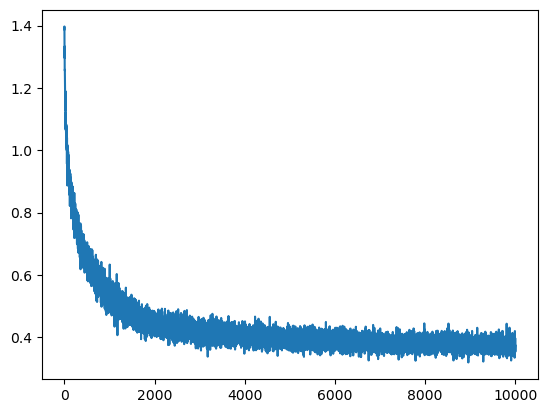

In [ ]:
plt.plot(stepi, lossi)

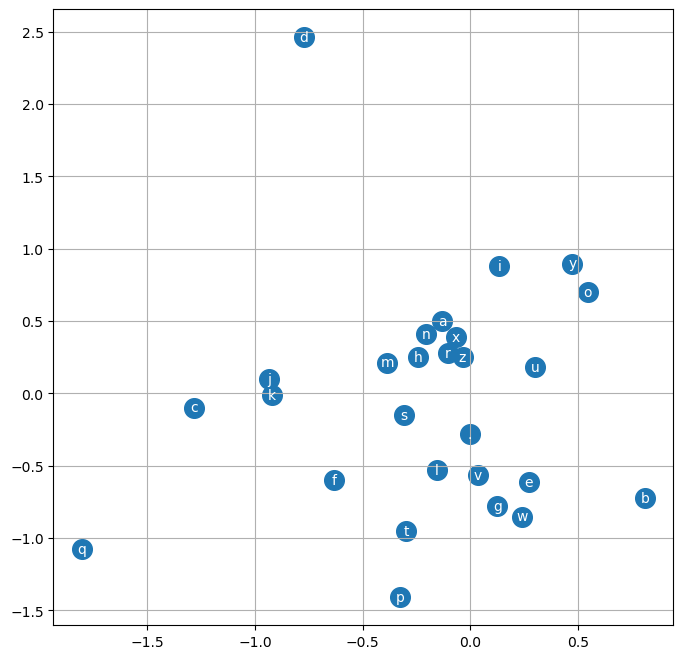

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0].data, embedding[:,1].data, s=200)
for i in range(embedding.shape[0]):
    plt.text(embedding[i,0].item(), embedding[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
g2 = torch.Generator('cuda').manual_seed(69)

for _ in range(20):
    out = []
    context = [0] * context_width
    while True:
        embeddings = embedding[torch.tensor([context])]
        h = torch.tanh(embeddings.view(1, -1) @ W1 + B1)
        logits = h @ W2 + B2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g2).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

janella.
misee.
oluwa.
makalyann.
kaela.
makariela.
emprend.
abell.
aileyza.
nika.
kadis.
merecia.
alara.
aubita.
des.
daria.
celen.
ahmir.
gameshaniking.
lakemor.
